In [4]:
from astropy import units as u
from astropy import time

import numpy as np

from poliastro import iod
from poliastro.bodies import Earth, Mars, Sun
from poliastro.ephem import Ephem
from poliastro.maneuver import Maneuver
from poliastro.twobody import Orbit
from poliastro.util import time_range
from poliastro.plotting import OrbitPlotter3D, StaticOrbitPlotter

# More info: https://plotly.com/python/renderers/
import plotly.io as pio

pio.renderers.default = "plotly_mimetype+notebook_connected"

from astropy.coordinates import solar_system_ephemeris


solar_system_ephemeris.set("jpl")

<ScienceState solar_system_ephemeris: 'jpl'>

In [2]:
# Initial data
date_launch = time.Time("2011-11-26 15:02", scale="utc").tdb
date_arrival = time.Time("2012-08-06 05:17", scale="utc").tdb
earth = Ephem.from_body(Earth, time_range(date_launch, end=date_arrival))
mars = Ephem.from_body(Mars, time_range(date_launch, end=date_arrival))
# Solve for departure and target orbits
ss_earth = Orbit.from_ephem(Sun, earth, date_launch)
ss_mars = Orbit.from_ephem(Sun, mars, date_arrival)
# Solve for the transfer maneuver
man_lambert = Maneuver.lambert(ss_earth, ss_mars)

# Get the transfer and final orbits
ss_trans, ss_target = ss_earth.apply_maneuver(man_lambert, intermediate=True)


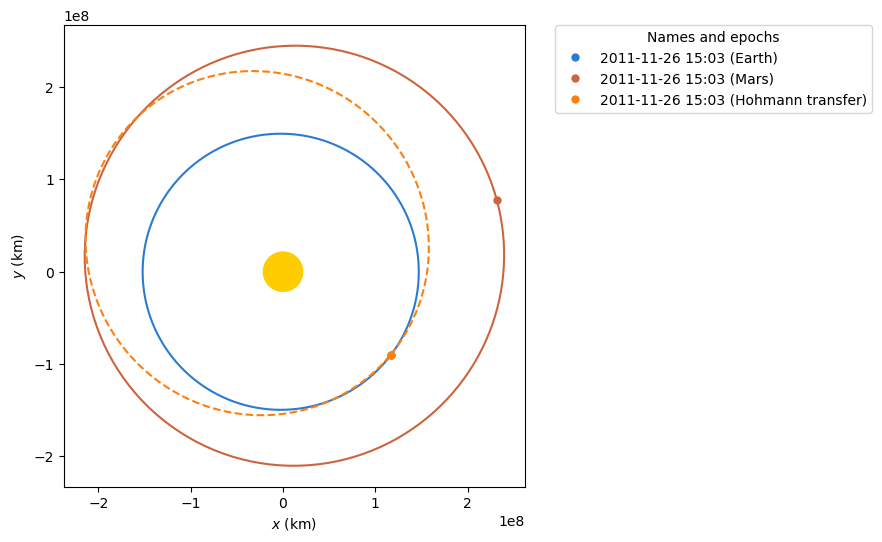

In [10]:

# We can check new bodies positions
plotter = StaticOrbitPlotter()
plotter.plot_body_orbit(Earth,  date_launch, label="Earth")
plotter.plot_body_orbit(Mars,  date_launch, label="Mars")

plotter.plot(ss_trans, color="C1", label="Hohmann transfer")


In [3]:
plotter = OrbitPlotter3D()
plotter.set_attractor(Sun)

plotter.plot_ephem(earth, date_launch, label="Earth at launch position")
plotter.plot_ephem(mars, date_arrival, label="Mars at arrival position")
plotter.plot_trajectory(
    ss_trans.sample(max_anomaly=180 * u.deg),
    color="black",
    label="Transfer orbit",
)
plotter.set_view(30 * u.deg, 260 * u.deg, distance=3 * u.km)